<a href="https://colab.research.google.com/github/sattar-iust/sattar-iust/blob/main/Advance_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This section is import section that I have added all python packages which might be needed during next codes.
Some of these packages should be installed before I can use them so, I will do that via ***pip install*** command.
Meanwhile, I implemented the code in Google Colab environment and in case of reproducing the code on other preferred environments, you have to specify such things as where you put the log files and how they are stored and retrieved.  

In [ ]:
pip install colour

In [ ]:
# import section

import glob
from google.colab import drive
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math
from colour import Color
import colorsys
import sklearn.preprocessing
from scipy.optimize import minimize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


Since I uploaded necessary files to my google drive, I should mount google drive to my Colab environment.

In [ ]:
# mounting of Robot Log Files into from google drive into Colab
drive.mount('/content/drive')

Mounted at /content/drive


So, before going deep into the code, it is better to gain some insights about what I'm going to do and what we will encounter with, some backgroung knowledge, indeed.
# Description
A robot is searching in a rectangular course, like fig .1 for a circular target. In this course, there are several obstacles which have different shapes such as rectangle and triangle but not circular. The robot tries to find the circular target as soon as possible with following an specific search method. The search will end whenever the robot finds the target or after 30 minutes, if the robot could not find the target the finding mission will fail. The robot can see up to 2 meters and reports its location as well as its 'sees' [1] which is a 360 degree view at determined time intervals.

So, the robot produces different log files for its searching process to locate the target, and our aim is to analyze these log files to fit a classifier which its output is the answer of this question: what the robot looking at is the circular target or not?

Hence, this work has nothing to do with robotics, searching methods, path finding, and so on, however we have to deal will numerous number of log files each contains different types of records which obtained through the robot's reports.
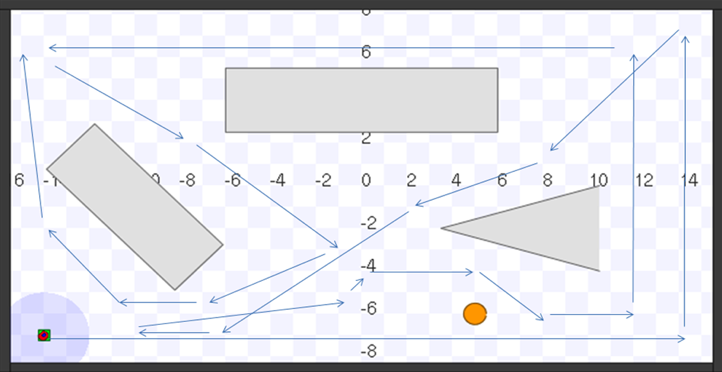

## A survey on log files
The robot produces one log file for each run, so if the robot runs for example 20 times, it ends up creating 20 log files. In this case, the files which we are dealing with contain 100 log files. By considering these files we can notice such matters as were the robot able to locate the target? how long did last the searching process? the speed of robot and the exact location of obstacle[1].
The folder of files consists 104 files, and it is easily observable that the file of each run is like "JRSPdata_2010_03_10_12_12_31.log" which starts with 'JRSPdata' and ends with '.log', and all files are text files rather than traditional csv files or excel files. So, we can load exact 100 names of log files or runs by using discoverd pattern.
It is possible to do a brief survey on the size and other specification of these files.
Many of files are size of 7 to 9 MB and the largest one is nearly 31 MB and by summing all of these sizes, it is noticeable that we have to deal with about 0.9 GB of data!

875.5639123916626

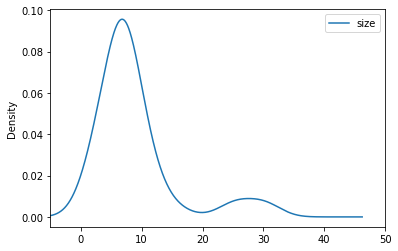

In [ ]:
#path = 'E:/Data Engineering - JUB/Second Semester/Advanced Project I/R Script'

# set the path along with pattern of files' names and then get names of 100 runs
# after that read size of all files
path = 'drive/MyDrive/RobotLogs/JRSPdata*log'
ff = glob.glob(path)
info = []
for filename in ff:
    info.append(os.stat(filename).st_size/1024**2)

# plot the density of file sizes
df = pd.DataFrame (info, columns = ['size'])
df.describe()
df.plot(xlabel='megabytes', xlim=[-5,50], kind='density')
df['size'].sum()

## Discovering meanings behind the files
The log file are text files and the structure of them follows the Player Project[2] which is a networked interface to robots and sensors.

It's likely a good idea to look a glance on the format of the files. Player log files have a simple text format. Messages are new-line separated, and any line beginning with a '#' is ignored. Every message line starts with common meta-data:

The fields are:

time (double): Timestamp, in seconds, associated with the message

host (uint): The 'host' part of the device's Player address

robot (uint): The 'robot' part of the device's Player address

interface (string): The 'interf' part of the device's

index (string): The 'index' part of the device's Player address

type (uint): The type of the message

subtype (uint): The subtype of the message

Following this common meta-data is the message payload, the format of which will depend on the interface, type, and subtype. [2] For our purpose, two formats are more significant, namely Laser format and Position2D format. You can find structure of these format at [3] and [4], respectively in detail. But for now, the fields of Position2D are as below:

px (float): X coordinate of the device's pose, in meters

py (float): Y coordinate of the device's pose, in meters

pa (float): yaw coordinate of the device's pose, in radians

vx (float): X coordinate of the device's velocity, in meters/sec

vy (float): Y coordinate of the device's velocity, in meters/sec

va (float): yaw coordinate of the device's velocity, in radians/sec

stall (int): Motor stall flag

Consequently, the files contain different records (lines), i.e, lines which start with # are comments, some lines might have 12 elements while some others might consist of 14 element with respect to 'interface'. So, we face a non-rectangular data since each line reflects varying number of values[1], this is one of challenging aspects of this project.

**First 11 lines of one log file**

\## Player version 2.1.3
\## File version 0.3.0
\## Format:
\## - Messages are newline-separated
\## - Common header to each message is:
\## time host robot interface index type subtype
\## (double) (uint) (uint) (string) (uint) (uint) (uint)
\## - Following the common header is the message payload
0000000000.100 16777343 6665 laser 00 004 001 +0.000 +0.000 0.000 0.156 0.155
0000000000.200 16777343 6665 position2d 00 004 001 -00.040 +00.000 +0.000 +00.440 +00.380
0000000000.200 16777343 6665 position2d 00 001 001 -14.000 -07.000 +0.785 +00.000 +00.000 +00.000 0
Basically, each line which starts with # can be ignored and next lines have seven fields of time, host, robot, interface, index, type, and subtype. Among these fields, time, interface, and type which indicates the type of message are significant for our work. Combination of interface 'position2d' and type '001' will depicts position (x, y) in meters, yaw coordinate of the offset of the device's center of rotation in radians and the device's length and width in meters[4]. (px, py, pa, vx, vy, va, stall) seven values!

Besides, lines which have interface of 'laser' and type 001 shows particularly [3]

scan_id (int): unique, usually increasing index associated with the scan

min_angle (float): minimum scan angle, in radians

max_angle (float): maximum scan angle, in radians

resolution (float): angular resolution, in radians

max_range (float): maximum scan range, in meters

count (int): number of readings to follow

list of readings; for each reading:

range (float): in meters

intensity (int): intensity

and after these 6 values, there are usually 361 pairs of range and intensity while the exact number of pairs is indicated by 'count'! So, these 361 pairs are the numbers which shows what the robots sees around it or 'LOOK'. The seeing process of the robot is as: the robot at each position commences to look its around starting from immediate behind itself and repeats in one degrees until 360 degrees, so the first and last view of the robot will always be same! Meanwhile, this process will happen after a laser record, hence, in that case we encounter with pairs of postion2d and laser records in a row. In other words, at an specific position, the robot evaluates its position and writes a record of 'position2d' in the log file, then the looking around process starts and the robots reports what it is seeing now through a Laser record, a 360 degree view!

We should consider that the maximum sight power of the robot is 2 meters, and then in pairs of (range, intensity) a range value less than 2 illustrates that the robot is seeing something (target, obstacle, or wall of the course) and range values of 2 means there isn't any visible object at that moment. (might have error)

## From log files to data set
We have to consider that these files are in text formats and the structure of lines are not same, i.e. it depends on the 'interface' and 'type' fields. It's better to keep in mind that both online and offline log files can be investigated and the codes to explore at both cases should be same.

Now, We are going to write a function by which reading all lines of files can be possible except the lines which start with # that should be ignored. This can be done through regular expressions like '^#'. After that, the lines are separated to mentioned fields again by using regular expression considering that the delimiter is space.

Through doing this tokenization, accessing to seven fields is possible and we are looking for the the lines which their interfaces are either 'Laser' or 'Position2D' at place of 4 and their type values are 001 at 6th place. Furthermore, we are interested in those lines which a laser line comes directly after a position2D line, since we are seeking for pairs of position-look of the robot.[1].

So far, we could fetch the required lines, split them into tokens, and grab the necessary fields. Now, it's time to convert them into data set, but we shouldn't lose sight of 361 'look' of the robot that can be extracted at next steps.

There are different approach to tackle this situation. How should be stored the data in the data set? We noticed that the laser and position records are of different sizes. Whereas position2d has 7 + 7 fields, Laser record consists of 7 + 6 fields along with at most case 361 pairs of range and intensity.

These two different records(lines) have 7 fields in common, as mentioned previous sections. First method can be an idea like: having an 8-column data set such that the 8th column stores a rather long string contains all 361 pairs of the robot's 'looks'. [1]. The second idea includes having two distinct data sets which one of them could contain common fields and the second one has to store payloads.

The third approach which might be the best one in terms of working conviently with while would not be so memory efficient way is as a data set with 3 columns for common necessary fields of time, x, and y of the robot and 361 columns for the range values[1]. Consequently, this approach will be used.

To get time, x and y of the robot's location, we have to refer to the indices of 1, 8 and 9 of tokens. And the next step is to extract payloads or looks of the robot which are 361 pairs. The starting index of them is 14 and each laser line contains 361 pairs.

In [ ]:
"""
a funtion to read a log file and extract required fields of each line and 
create a data frame as return value.
"""
def readLog(filename = "/content/drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_31.log"):

  lines = []
  els = []
  locations = []
  ranges = []

  # read those lines which do not start with # character
  with open(filename) as f:    
    for line in f:
      if not (re.search("^#", line)):
        lines.append(line)
        els.append(line.split())
  # find the position (time, x, y) corresponding to a position2d 
  # with a laser immediately after.
  # and grab the 361 ranges from next line i+1
  for i in range(len(els)):
    if (els[i][3] == 'position2d' and els[i][5] == '001' and 
        els[i+1][3] == 'laser' and els[i+1][5] == '001'):
      locations.append([els[i][0], els[i][7], els[i][8]])
      oneRange = []
      for j in range(13, 735, 2):
        oneRange.append(els[i + 1][j])
      ranges.append(oneRange)
  # convert the locations and ranges to data frame
  df_loc=pd.DataFrame (locations, columns = ['time', 'x', 'y'])
  df_ran=pd.DataFrame (ranges, columns = ["range{}".format(i) for i in range(1,362)])
  df_ans = pd.concat([df_loc, df_ran], axis=1)
  
  # convert to numeric data frame and return it
  return (df_ans.apply(pd.to_numeric))

# EDA on log files
After implementation a function which can read a log file and return a data set of required fields such time, location, and 'looks' of the robot, now it time to read all 100 log files to do a survey on them.

In [ ]:
"""
this part of code will simluate EDA of the R codes and draw necessary plots and produce the results.
"""
# read all log files, it might take more than 5 minutes!
logs = []
for fn in ff:
  logs.append([readLog(fn), fn])


The result of above command would be 100 data frames which each of contains variable number of observations with 364 features.

## Looking at the distribution of experiments’ duration
That means how many seconds each experiment lasted. Since the records are in ascending order with respect to time, this process is as simple as subtracting the last row's of time from time of first row for each log file.

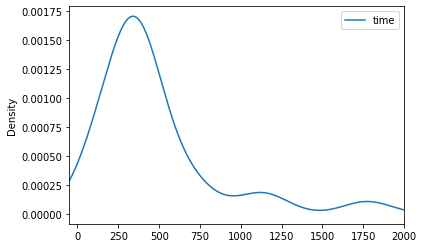

In [ ]:

# plot the distribution of run's duration
dur = []
for log in logs:
  #dur.append(log[0].loc[:,'time'].max() - log[0].loc[:,'time'].min())
  #dur.append(log[0].iloc[-1].at['time'] - log[0].loc[0].at['time']
  dur.append(log[0]['time'].max() - log[0]['time'].min())
# plot the density of run's duration
df = pd.DataFrame (dur, columns = ['time'])
df.plot(xlabel='time', xlim=[-50, 2000], kind='density')


You can see that in above figure, there are three distinct modes namely around 400 sec, 1200 sec, and 1700 sec.

## Other insights


1. Do all robots remain in the course borders or not?
We knew that the course area is in the range of -15 to +15 and -8 to +8 horizontally and vertically, respectively. So, it seems that all robots were able to be within the course.
2. Are the times in all log files sorted correctly?
The ‘True’ result tells us that the differences between times of all log files are positive which means each record’s time value is greater than time value of previous record.


3. Is there a robot which experiences difficulties in its functionality, i.e. it could not pursue its path?
The results illustrates that maximum time gap is around 9 seconds, i.e. at lease one robot could not work for about 9 seconds. On the other words, one robot did write its records in the log file for nearly 9 seconds. The log file of this robot is ‘JRSPdata_2010_03_10_12_39_46.log’

It can be seen that a robot could not do its work for around 9 seconds that it log files is ‘JRSPdata_2010_03_10_12_39_46.log’. The question is, why did this robot make such big delay?

To find the answer of this question, we should go through its log file in depth, and then we noticed that the corresponding position2D record of this record contains stall is true. That means this robot experienced a kind of motor problem and it seems the robot stopped for a while.
4. Comparing the number of rows log files can reveal that the how fast the robot could be able to find its path.
The diagram shows that most of log files consists of 2000 to 4000 records which completely consistent with the figure that reflects distribution of run’s duration.
5. exploration of how robots move
As we all have learned from high school, velocity is derivation of position regarding time. Our data set has two features for position which are x, y and one feature of time. So, first the change of x and y positions should be obtained and next plotting them is possible.
what we can get from these figures:

  * the robots’ movements are around 0 which means that the robot moves rather small distances at both directions, vertical and horizontal.

  * The range of movement at vertical direction is narrower than horizontal direction, which are [-0.2, +0.2] and [-0.5, +0.5], respectively. It is in consistent with the course area since the width of course area is approximately as two times as its height.

  The plot of velocity reflects that how fast the robots move. Obviously, there are two distinct groups of robots, the robots that move fast roughly 0.8 meters per second and slow robots with speed of less than 0.2 meters per second.

**Question: why do not we use speed fields of vx and vy in position2d records?**

Because in records of position2d and type value 001, the robot is standstill and looking around to make a 361-degree look or payload, so the vx and vy of these position2d record are always zero.

In [ ]:
# finding whether all robots remain in the course borders or not
dur = np.arange(4*len(logs), dtype='float64').reshape(len(logs),4) # minx, miny, maxx, maxy
i = 0
for log in logs:
  dur[i][0]= log[0]['x'].min() 
  dur[i][1]= log[0]['x'].max() 
  dur[i][2]= log[0]['y'].min() 
  dur[i][3]= log[0]['y'].max() 
  i += 1

print('min and max of x in the course are: {}, {}'.format(dur[:,0].min(),dur[:,1].max()))
print('min and max of y in the course are: {} ,{}'.format(dur[:,2].min(),dur[:,3].max()))


min and max of x in the course are: -14.91, 14.546
min and max of y in the course are: -7.713 ,7.316


In [ ]:
# Are the times in all log files sorted correctly?
# result for each data frame == 100
dur = np.ones(len(logs), dtype=bool) 
i = 0
for log in logs:
  dur[i] = all(log[0].loc[:,'time'].diff().dropna()>=0)
  i += 1
print('Are time columns of all log files in ascending order? {}'.format(all(dur)))


Are time columns of all log files in ascending order? True


In [ ]:
# check the time gaps of all log files
# deltas keeps the time differences of all logs! 
# here I have calculated the Diff of x and y which I will need for the next parts.
deltas = pd.DataFrame(columns = ['timeDiff','filename', 'dx', 'dy'])
for log in logs:
  timeDiff = pd.DataFrame(list(log[0]['time'].diff().dropna()), columns = ['timeDiff'])
  dur = [log[1]]*len(log[0])
  fname = pd.DataFrame(dur, columns = ['filename'])
  dx = pd.DataFrame(list(log[0]['x'].diff().dropna()), columns = ['dx'])
  dy = pd.DataFrame(list(log[0]['y'].diff().dropna()), columns = ['dy'])
  time = pd.DataFrame(log[0]['time'], columns = ['time'])
  deltas = deltas.append(pd.concat([time, timeDiff, fname, dx, dy], axis=1), ignore_index=True)
print('Summary of time differences of all logs')
print(deltas.describe())

Summary of time differences of all logs
            timeDiff             dx             dy           time
count  266541.000000  266541.000000  266541.000000  266641.000000
mean        0.174550       0.002828       0.002675     347.086677
std         0.075784       0.081299       0.055332     345.193665
min         0.100000      -1.040000      -0.514000       0.200000
25%         0.100000      -0.004000      -0.001000     106.900000
50%         0.200000       0.000000       0.000000     238.700000
75%         0.200000       0.007000       0.001000     450.600000
max         8.800000       0.960000       0.560000    1799.900000


In [ ]:
# find the log which has the maximum time difference 
# which means a robot with this time gap perhaps stopped!
# and this robot belongs to which log file.

print(deltas.nlargest(5, 'timeDiff'))

       timeDiff                                           filename   dx  \
37713       8.8  drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12...  0.0   
25522       1.5  drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12...  0.0   
24720       1.3  drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12...  0.0   
1232        1.3  drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12...  0.0   
35365       1.3  drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12...  0.0   

          dy    time  
37713  0.000   382.1  
25522  0.000  1565.2  
24720  0.000  1358.1  
1232  -0.007   210.2  
35365  0.000  1706.9  


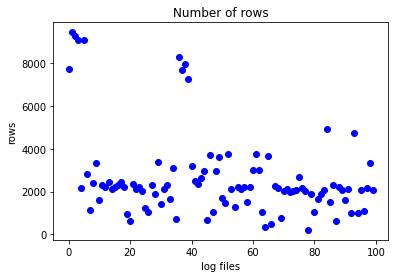

the sum of all rows is: 266641


In [ ]:
#Comparing the number of rows log files and plot a scatter 
dur = []
for log in logs:
  dur.append(len(log[0]))

plt.plot(dur, 'bo')
plt.xlabel('log files')
plt.ylabel('rows')
plt.title('Number of rows')
plt.show()
print('the sum of all rows is: {}'.format(sum(dur)))

[Text(0, 0.5, 'Rows'), Text(0.5, 1.0, 'Number of Rows')]

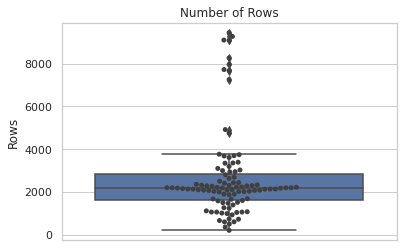

In [ ]:
# a boxplot for the above diagram
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y=dur)
ax = sns.swarmplot(y=dur, color=".25")
ax.set(title='Number of Rows', ylabel='Rows')

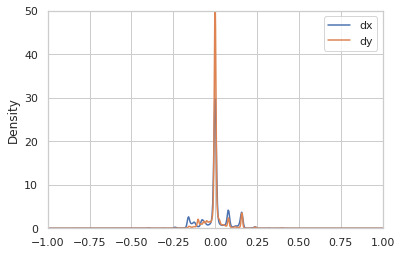

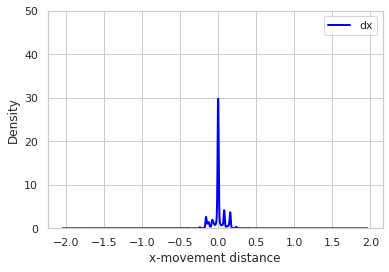

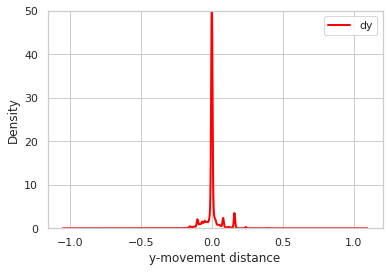

In [ ]:
# exploration of how robots move
# I computed the delta x and delta y during previous parts and
# they are in delats data frame
deltas.plot(y = ['dx','dy'],  kind='density', xlim=[-1, +1], ylim=[0,50])
deltas.plot(y = ['dx'],  kind='density', ylim=[0,50], color = 'blue', linewidth=2)
plt.xlabel('x-movement distance')
deltas.plot(y = ['dy'],  kind='density', ylim=[0,50], color='red', linewidth=2)
plt.xlabel('y-movement distance')

plt.show()


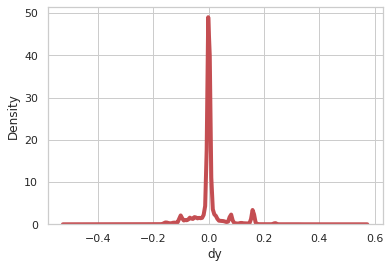

In [ ]:
sns.kdeplot(deltas['dy'], shade=False, color="r", linewidth=4)

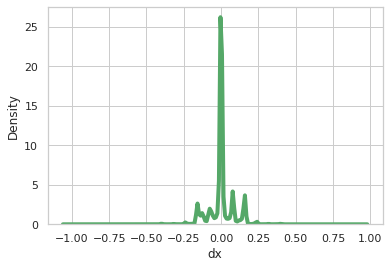

In [ ]:
sns.kdeplot(deltas['dx'], shade=False, color="g", linewidth=4)

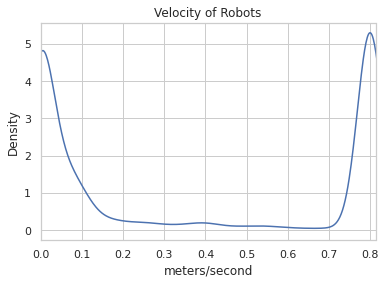

In [ ]:
# Now, we can calculate the velocity of robots.

deltas['velocity'] = np.sqrt((deltas['dx']**2 + deltas['dy']**2))/deltas['timeDiff']
deltas['velocity'].plot(kind='density')
plt.xlabel('meters/second')
plt.title('Velocity of Robots')
plt.xlim([0, deltas['velocity'].max()])
plt.show()

In [ ]:
#We also want to examine the distribution of the range values of all of the looks.
# check for one file and it can be done for all other 100 log files.
logs[0][0].iloc[:, 3:-1].describe()

,range1,range2,range3,range4,range5,range6,range7,range8,range9,range10,...,range351,range352,range353,range354,range355,range356,range357,range358,range359,range360
count,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,...,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000,7725.000000
mean,1.354827,1.353029,1.352249,1.351476,1.350880,1.351203,1.351641,1.353055,1.354526,1.356051,...,1.374114,1.371128,1.369575,1.368895,1.367277,1.367564,1.366978,1.362815,1.358708,1.354666
std,0.159205,0.153838,0.148647,0.143626,0.139254,0.134786,0.130773,0.126819,0.123140,0.119734,...,0.156458,0.159656,0.164240,0.171663,0.176165,0.183723,0.188467,0.178013,0.168066,0.158693
min,1.260000,1.260000,1.261000,1.262000,1.263000,1.265000,1.267000,1.269000,1.272000,1.276000,...,1.279000,1.276000,1.272000,1.269000,1.267000,1.265000,1.263000,1.262000,1.261000,1.260000
25%,1.300000,1.300000,1.301000,1.302000,1.303000,1.305000,1.307000,1.310000,1.313000,1.316000,...,1.320000,1.316000,1.313000,1.310000,1.307000,1.305000,1.303000,1.302000,1.301000,1.300000
50%,1.320000,1.320000,1.321000,1.322000,1.323000,1.325000,1.327000,1.330000,1.333000,1.336000,...,1.340000,1.336000,1.333000,1.330000,1.327000,1.325000,1.323000,1.322000,1.321000,1.320000
75%,1.320000,1.320000,1.321000,1.322000,1.323000,1.325000,1.327000,1.330000,1.333000,1.336000,...,1.340000,1.336000,1.333000,1.330000,1.327000,1.325000,1.323000,1.322000,1.321000,1.320000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


# Visualization
In this section, I am trying to visualize the path which robots traverse among obstacles within the course to find a circular target.
## Path visualization
In this section, we have to visualize paths of robots by which it is possible to detect multiple obstacles in the course and by investigation of ‘looks’ we should find a way to identify circular target. So, we need to develop a classifier that detects circular target in a specific look.

So far, we have some insights over robots’ movement, velocity, x and y of the course by means of calculation of various distributions and diagrams on looks of robots in log files. Meanwhile, there are other aspects to be considered such as what paths robots captured and to what extend the robots were able to cover the course.

First, I will plot the path for the first log file which the robot went through it. Remember that our course’s dimension is -16 to +16 and -8 to +8, horizontally and vertically, respectively.  

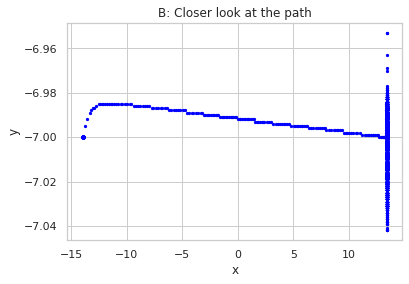

7725
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_31.log


In [ ]:
# plotting x vs. y for the robot of first log file
# and the limitations of x and y in the graph show the course borders.

logs[0][0].plot(x = 'x', y='y', marker='.', kind='scatter', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('B: Closer look at the path')
plt.show()  
print(len(logs[0][0]))
print(logs[0][1])

The robot started from left bottom corner of the course, after a negligible vertical movement upward (about 0.02 meter) it went along side the bottom border of the course and reached near the right border of the course and took upward and downward movements there by range of -0.04 and +0.04.
The following diagram illustrates that the robot took its movement along the bottom side of the course and it can be said that this robot always moved horizontally and there was a slight vertical movement.
Actually, this plot is as same as the above diagram and the only difference between them is limitations over x and y axes.

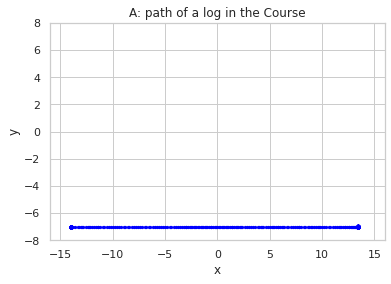

In [ ]:
# plot with course's limitations
logs[0][0].plot(x = 'x', y='y', marker='.', kind='scatter', color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-16,+16])
plt.ylim([-8,+8])
plt.title('A: path of a log in the Course')
plt.show()

## Add direction to paths
Note that, we cannot detect any thing about the direction which the robot followed from these plots. We know the direction based on our course and background knowledge that we know robot would start its work from left bottom corner. Then, the next improvement of these plots is that we should add directions to them. How is possible to add direction of robot to this plot?

First, we can indicate end and last of direction by some special characters such as a circle and a cross(function: points()). Next, changing characters of plot to smaller and more attractive signs would be helpful. To show direction to the plot, one solution is to put arrows alongside the direction, however, this approach is not so practical since we have to plot these arrows on the dots and it can lead to overplotting.

A more appropriate approach could be using of colors that change gradually from, like green which reflects starting point to red indicated end point. So, for each row, it’s possible to attach a color via rgb() function of R. RGB has three color vectors and we like to use only red and green colors and so value of blue color will be set to 0.

In [ ]:
# a function to create vectors for colors to color map of direction
def makeColorRamp(n):
  green = Color("green")
  col = list(green.range_to(Color("red"),n))
  for i in range(len(col)):
    col[i] = Color.get_hex(col[i]) 
#  col = np.zeros((n, 3))
#  col[:,0] = range(1,n + 1)
#  col[:,0] = col[:,0] / (n+1)
#  col[:,1] = 1- col[:,0]
  return col

In [ ]:
# a function to create vectors for colors to color map of direction
# which is my function and divide the postions into 25 group which will has one color
# one of exercises of the book.
def makeColorRamp2(n, nc = 10):
  green = Color("green")
  col = list(green.range_to(Color("red"),nc))
  for i in range(len(col)):
    col[i] = Color.get_hex(col[i])
  col[len(col)-1] = '#FF0000'
#  col = np.zeros((n, 3))
#  col[:,0] = range(1,n + 1)
#  col[:,0] = col[:,0] / (n+1)
#  col[:,1] = 1- col[:,0]
  ret = []
  for cl in col:
      ret += [cl]* int(n/nc)

  for i in range(int(n/nc)*nc,n):
    ret.append(col[nc - 1])
  
  return ret

Then, a function which can plot a path for an experiment.

In [ ]:
# a function which can plot a path for an experiment. 
def plotRobotLog(x,y, obstacles = False, limit = True):
  #print(set(makeColorRamp2(len(x))))
  plt.scatter(x=x, y=y, marker='.', color=makeColorRamp(len(x)))
  if limit:
    plt.xlim([-16,+16])
    plt.ylim([-8,+8])
  # first point
  plt.scatter(x[0], y[0], c = 'Black', marker='*', s=100)
  plt.scatter(x[len(x)-1], y[len(x)-1], c = 'Red', marker='*', s=100)
  plt.rcParams['figure.figsize'] = (16,8)
  if obstacles:
    # plot obstacles of the course
    plt.plot([6,6,-6,-6,6],[2.2,5.2,5.2,2.2,2.2],color="black", linewidth=3)
    plt.plot([-6,-11,-13,-8,-6],[-3,2.4,0.8,-4.4,-3],color="black", linewidth=3)
    plt.plot([9.5,9.5,3,9.5],[-4,0,-2,-4],color="black", linewidth=3)
  return


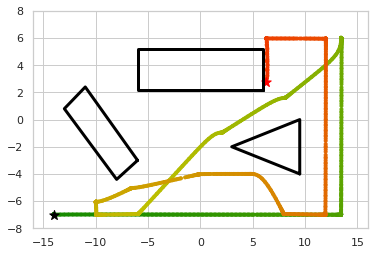

In [ ]:
plotRobotLog(logs[10][0]['x'], logs[10][0]['y'], True)

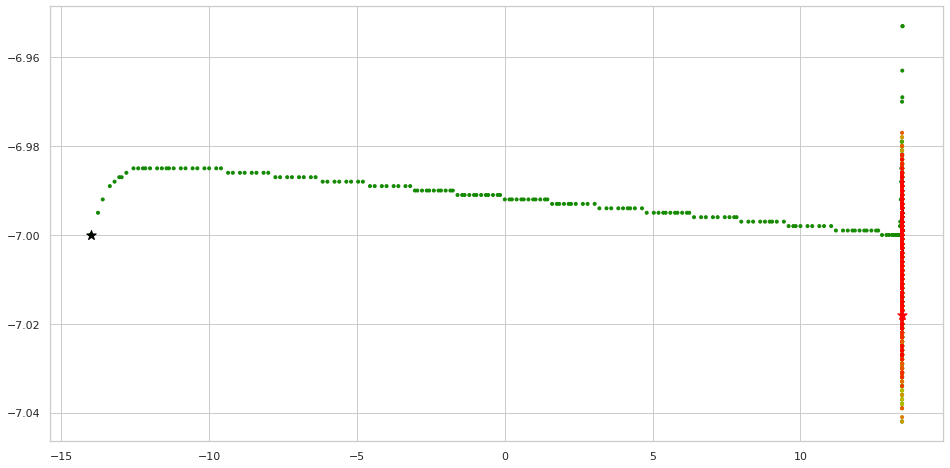

In [ ]:
plotRobotLog(logs[0][0]['x'], logs[0][0]['y'], limit=False)


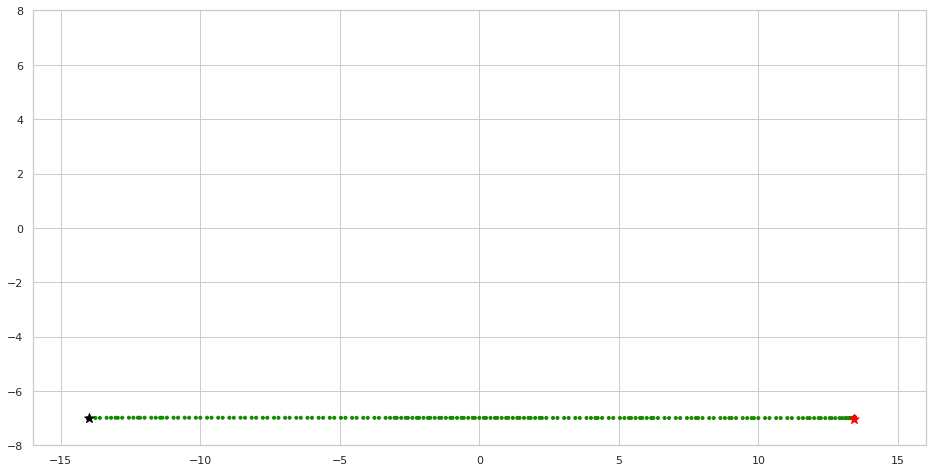

In [ ]:
plotRobotLog(logs[0][0]['x'], logs[0][0]['y'], limit=True)

And finally, this new function can be applied to plot paths of all experiments.

In [ ]:
# plot all paths for all experiments

# Initialise the subplot function using number of rows and columns
def PlotRobotLogs():

  figure, axis = plt.subplots(10, 10)

  for i in range(10):
    for j in range(10):
      #plotRobotLog(logs[0][0]['x'], logs[0][0]['y'])
      x = logs[i*10 + j][0]['x']
      y = logs[i*10 + j][0]['y']
      axis[i,j].scatter(x=x, y=y, marker='.', c=makeColorRamp(len(x)))
      axis[i,j].set_xlim([-16,+16])
      axis[i,j].set_ylim([-8,+8])
      axis[i,j].set_axis_off()
      # first point and last point
      axis[i,j].scatter(x[0], y[0], c = 'Blue', marker='o', s=50)
      axis[i,j].scatter(x[len(x)-1], y[len(x)-1], c = 'Black', marker='X', s=50)
      plt.axis('off')
      plt.rcParams['figure.figsize'] = (16,8)

  plt.show()
  return

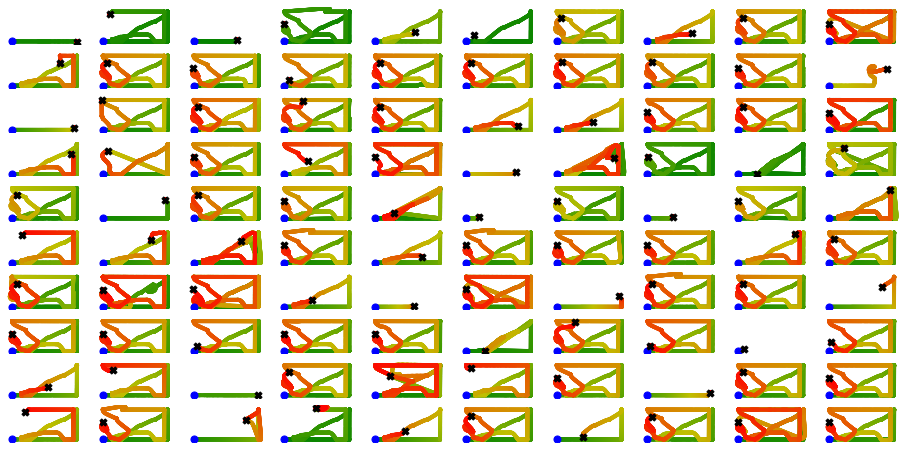

In [ ]:
PlotRobotLogs()

## Exploring a LOOK
The main aim of this case study is how to recognize and to detect a circular target across the course and we know that the radios of the target is known. So, first we have to be more familiar with concept of a look which is something that the robot can see.

In our data, i.e 100 log files we have exactly 266541 looks. As we have noticed, the robot can see nothing, triangular and rectangular objects which are obstacles and circular target. Initially, we start to implement a function to plot a look.

We have the location of robot and the values for every one degree of its observations which are 361 degrees and the last degree and first degree are same. It the book, the approach is using a polar coordinates since there are a 360 degree view and a range for each degree and so the exact location of what the robot is observing right now is represented by a degree and a range. Then by using polar coordination we can compute the distance of each location from robot’s place. Consequently, the range of each degree should be multiplied by cos and sin of the angle and added to the robot’s coordination.

Suppose a circle with radios of 2 meters and at the origin of this circle, a robot stands and is looking around it. This circle will be plotted as red line and the actual objects which the robot is seeing now, will be plotted by black color. The robot starts to look its around from its behind and so 90 degree should be subtracted and the starting point of looks will be (0,1) instead of (1,0).

In [ ]:
# a function to plot a look
# first row of a data frame
def plotLook(logRow, ttmain = ''):

  #xdata = float(logs[0][0].iloc[-1:]['x'])
  #ydata = float(logs[0][0].iloc[-1:]['y'])
  xdata = float(logRow.iloc[-1:]['x'])
  ydata = float(logRow.iloc[-1:]['y'])

  theta = np.linspace(-np.pi/2, (3*np.pi)/2, 360) # start from behind -90
  #r = logs[0][0].iloc[-1: , 3:-1].to_numpy()
  r = logRow.iloc[-1: , 3:-1].to_numpy()

  x1 = xdata + r*np.cos(theta)
  y1 = ydata + r*np.sin(theta)

  # a circle of radius 2 meters
  plt.plot(xdata + 2*np.cos(theta), ydata + 2*np.sin(theta), marker='.', color = 'red', markersize=0.5)

  # actual points
   # what the robot sees
  #plt.scatter(x=x1, y=y1, c = 'blue', s = 10)
  plt.plot(x1, y1, marker='*', markersize=1.5, color = 'blue')
  plt.gca().set_aspect('equal')
  plt.rcParams['figure.figsize'] = (16,8)
  plt.title("Look of {}".format(ttmain))
  return

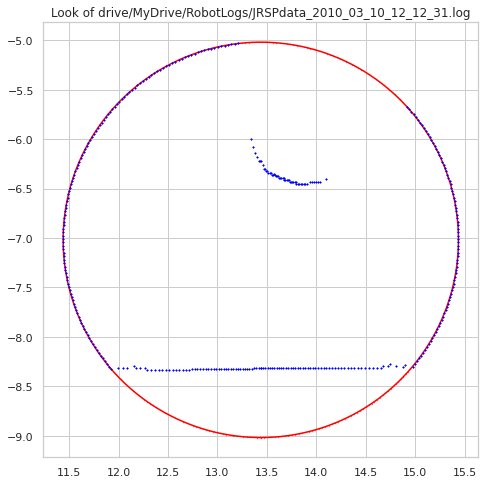

In [ ]:
plotLook(logs[0][0].iloc[-1:], logs[0][1])

and draw looks of all log files, but only for the final looks!

In [ ]:
# a function to plot all 100 final looks of log files
def plotLooks():
  figure, axis = plt.subplots(10, 10)

  for i in range(10):
    for j in range(10):
      #plotRobotLog(logs[0][0]['x'], logs[0][0]['y'])


      xdata = float(logs[i*10 + j][0].iloc[-1:]['x'])
      ydata = float(logs[i*10 + j][0].iloc[-1:]['y'])

      theta = np.linspace(-np.pi/2, (3*np.pi)/2, 360) # start from behind -90
      r = logs[i*10 + j][0].iloc[-1: , 3:-1].to_numpy()

      x1 = xdata + r*np.cos(theta)
      y1 = ydata + r*np.sin(theta)

      # a circle of radius 2 meters
      axis[i,j].plot(xdata + 2*np.cos(theta), ydata + 2*np.sin(theta), marker='.', color = 'red', markersize=0.5)

      # actual points
      # what the robot sees
      #axis[i,j].scatter(x=x1, y=y1, c = 'blue', s = 1)
      axis[i,j].plot(x1, y1, marker='.', color = 'blue', markersize=1)
      #axis[i,j].plot(x1, y1, marker='.', markersize=1.5, color = 'blue')
      axis[i,j].set_axis_off()
      axis[i,j].set_aspect('equal')
      plt.axis('off')
  plt.rcParams['figure.figsize'] = (24,16)
  plt.show()
  return

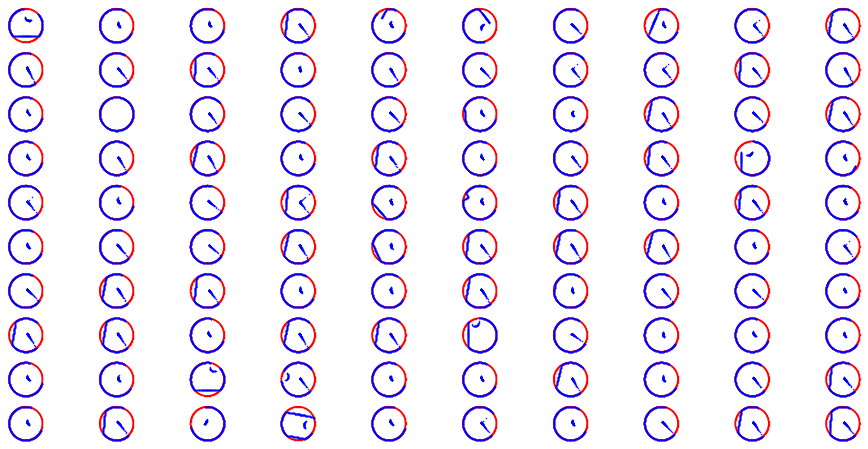

In [ ]:
plotLooks()

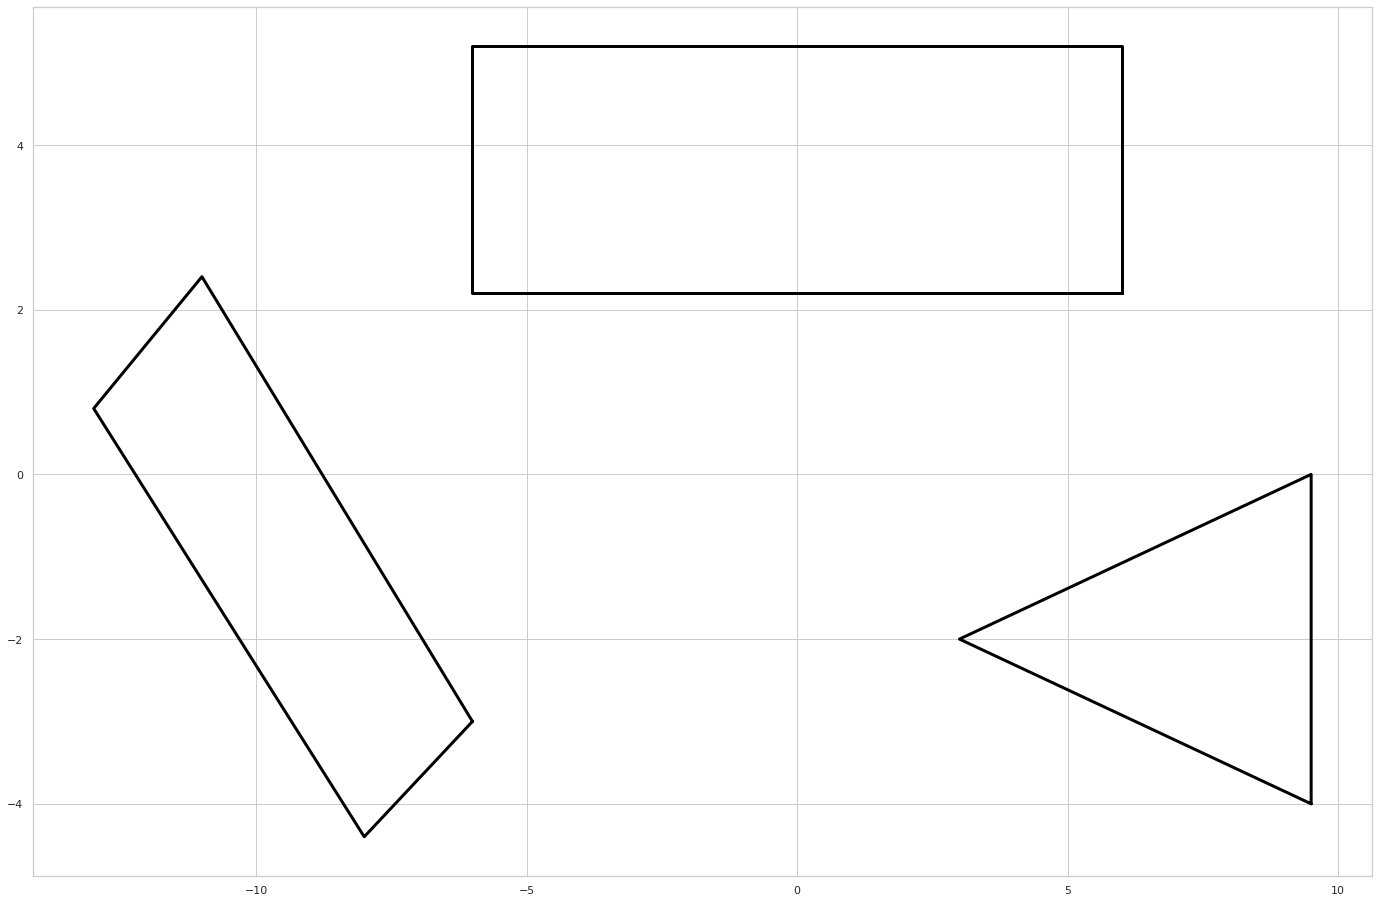

In [ ]:
# plot obstacles of the course
def plotObstacles():
  plt.plot([6,6,-6,-6,6],[2.2,5.2,5.2,2.2,2.2],color="black", linewidth=3)
  plt.plot([-6,-11,-13,-8,-6],[-3,2.4,0.8,-4.4,-3],color="black", linewidth=3)
  plt.plot([9.5,9.5,3,9.5],[-4,0,-2,-4],color="black", linewidth=3)
  return

plotObstacles()


# Error
While we were able to visualize the look of robots via a circle of 2 meters radius, we have realized that there are some jerks at the end of obstacles’ and target’s borders. For instance, at previous figure, you can see these jerks an two ends of the bottom line which might correspond to a rectangle obstacle. These are likely to stem from random errors that measurement of this error could help to estimate uncertainty of our classifier.

Since the robot does only one measurement process at each distinct position, so there aren’t repetitive measurement numbers for one position. Consequently, it is not plausible to utilize distribution of error or standard deviation.

As we have explained, the robot does its measurement for every position by looking around and produces a range number at each one degree and it does the procedure for 361 times. Therefore, it makes 361 range values for each view such that the first and the last range values will be same. This situation is the only repeated data which we have.

Consequently, we can work on this situation to get insights about error.
They all show 0 and we know that the ranges are measured with precision of 3 decimal points which is millimeter level. So, if there is error, it should be beyond millimeter level.

Are there other repeated data which we can use them to investigate error? There are a few situations in which we might encounter repetitive measurement by a robot. As a tangible example, a robot may visit a place more than once in an experiment, so we can compare its measured range in that position to discover whether there is an error or not. Or, it is possible that two robots visit several same locations so that this phenomenon can be detected via looking into different log files. Nevertheless, we cannot rely on it to estimate error (i.e. same locations of different robots) due to two robots might have different measurement approaches and techniques or even they might experience nonidentical conditions.

Then, we should concentrate on a robot visiting a location more than once. That means finding duplicated positions in a log file. So, we first create a new feature which comprises both x and y and call it ‘pos’.
So, we can find duplicated positions by means of duplicated() function and store them as ‘w’. And all duplicated rows of a data frame were piled on a data frame.
This part works as following:

First, it makes groups of same positions, and then calculates mean of each column. After that the value of each range is subtracted from its column’s mean.
The procedure of error calculation can be done for all log files through following function and it produces over 38 million numbers! Meanwhile, calculation of standard deviation is possible and we are able to plot density distribution of these errors.

In [ ]:
# this part will compute errors!
# error is defined as: 
# 1- find the repeated postions in a log file.
# 2- group by this log file based on duplicated postions
# 3- calculate mean of each range coloum through each group
# 4- substract each range value from mean of its column
# 5- do steps 1 to 4 for all log files!
# the selcted log file to test: RSPdata_2010_03_10_12_39_46  == logs[7]
def getRangeError(tmp = logs[4][0]):

  #tmp = logs[4][0]
  # find duplicated positions
  bool_series = tmp.duplicated(subset=['x','y'], keep = False) 
  tmp = tmp[bool_series]

  # steps of 2 to 4 : each range value - mean of each group  
  demean = lambda df: df - df.mean()
  return (tmp.groupby(['x','y']).transform(demean).iloc[:,1:362])

# a function to do step 5
def getRangeErrors():
  errs = pd.DataFrame(columns = ["range{}".format(i) for i in range(1,362)])
  # iterate over 100 log files and call getRangeError
  for log in logs:
     errs = errs.append(getRangeError(log[0]), ignore_index=True)
  
  return errs.to_numpy().flatten()


In [ ]:
errors = getRangeErrors()
# errors has 38/931/684 values!!

Text(0, 0.5, 'Density')

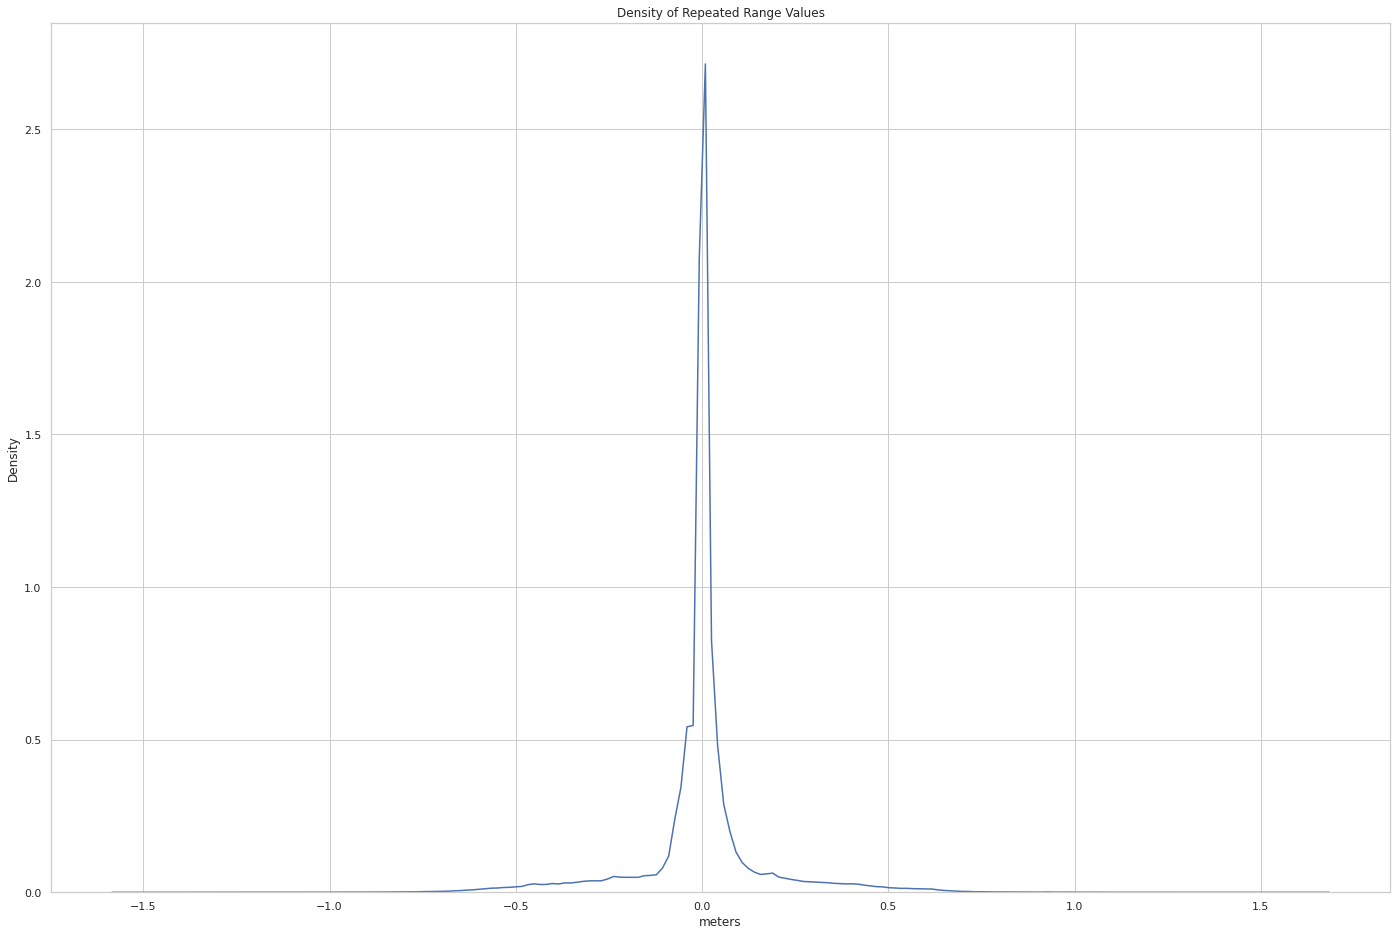

In [ ]:
#Density of Repeated Range Values
sns.kdeplot(errors , fill = False)
# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density of Repeated Range Values')
plt.xlabel('meters')
plt.ylabel('Density')

So, at the end of this section we realized that there is no significant error in our data and the density distribution of errors shows that majority of error values is zero or near zero.

# Detecting a circular target
So far, we have done a rather comprehensive survey on log files and gained roughly detailed insights of the data. The ultimate aim of this case study, however, is to find an approach to detect a circular target with given radius which is 0.5 meter. This work should be done on the look of robots while there are several looks in a log file. Hence, it was decided in the book that only last looks of log files should be considered, although each record of these 100 data frames is a look and we have exactly 266641 looks!

## Finding segments
First, we draw 12 of the final looks to survey their characteristics. We can observe 4 distinct types of looks in this figure.

1- a robots sees nothing. Then there is not any circular target in the look.

2- robot sees a straight line or two straight lines which may cross each other, but without any circular target.

3- robot merely sees a circular target.

4- robot sees circular targets along with parts of one or two obstacles.

Considerations of detecting circular target:

To detect a circular target we realized that some considerations should be taken into account:

To find the target, we don’t have information about entire 360 degrees of the circular target. We only could look at relatively short arc-like segment of the target. As you might realize from the look views of the above figure.

By default, we have to look at objects which is located at range of 2 meters, since beyond 2 meters the robot cannot see any thing. So, we are not interested in range values which are equal 2 and only consider those values which are less that 2.

The first and last range values are identical, as we discussed it before. Hence, range value of 361st degree should be neglected.

Consequently, we have to search and find segments which their range values are less than 2 meters. To do so, through a loop, we start from the first value of ranges and find the first range value which is less than 2 meters. This is the starting point of the fisrt segment and then going forward to the end of this segment (i.e. reaching next range value of 2 meters). And we should repeat this process throughout the 360 range values.

There are several values to implement this search. For instance, using a logical vector with condition of range < 2 and a loop over vector to find first true values and separate the segments.

The more efficient way to do this search is R function rle() or run length encoding which finds contiguous segments of a vector that have the same value and returns the lengths of these segments and the value of each separate segment[1].

To fulfill this procedure, the book uses rle() function on a vector with condition of range < 2. It will find the range values which are less than 2 meters. Then by exploiting the length of these regions it is possible to detect the first and last range values of each segment.

In [ ]:
# implementation of getSegments funtion which detects segments of looks
# last look of a robot with just range columns 
#print(logs[0][0].iloc[-1: , 3:-1])

# this function accepts a row of a data frame of log file
def getSegments(rangeLog, threshold = 2):
  #x = logs[0][0].iloc[-1: , 3:-1] < 2
  if isinstance(rangeLog, pd.DataFrame):
    seq = rangeLog.iloc[: , 3:-1] < threshold
    seq = seq.values.flatten().tolist()
  else:
    seq = []
    for i in range(len(rangeLog)):
      if (rangeLog[i]<threshold):
        seq.append(True)
      else: seq.append(False)

  compressed = []
  count = 1
  char = seq[0]
  find = 0
  lind = 0
  for i in range(1,len(seq)):
    if seq[i] == char:
      count = count + 1
      lind += 1
    else :
      compressed.append([char,count, find, lind])
      char = seq[i]
      count = 1
      find = lind = i
  compressed.append([char,count, find, lind])
  ret = []
  for i in range(len(compressed)):
    if (compressed[i][0] == True):
      ret.append([*range(compressed[i][2],compressed[i][3]+1,1)])
  #print(compressed)
  return ret


In [ ]:
# test with last look of the first log
t = getSegments(logs[0][0].iloc[-1: ,])
# test with first look of first log
t = getSegments(logs[0][0].head(1))

In [ ]:
import random
lst = [2.0] * 360
for i in range(20,29) : lst[i] = 1.7 
for i in range(80,104) : lst[i] = 1.4 
for i in range(164,204) : lst[i] = 0.35 
# test with a fake look
getSegments(lst, 1.6999)

[[80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103],
 [164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  178,
  179,
  180,
  181,
  182,
  183,
  184,
  185,
  186,
  187,
  188,
  189,
  190,
  191,
  192,
  193,
  194,
  195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203]]

## Connecting segments behind the robot
There is a problem on segmentation function which we have implemented at the last section. Although, this problem does not stem from the implementation logic which we used at the function, we have to look at the procedure of robot’s looking around.

I’d like to explain this problem with a specific log file as instance. We have plotted the final look of the first log file at previous sections and you can see it aging here. As you absolutely noticed, there are two segments that one is an arc of circular object at the top and the second is a line which might show a rectangular object in the bottom. Now, if we get output of segmentation function, it tells us there are 3 segments!

What is the reason of this problem? To answer this difficulty which we have noticed, it is better to review again the process of how the robot sees its around and reports the range values. At each position, robot looks its strait behind and sends range values at each degree on the direction of counter clockwise until it covers 361 degrees.

Suppose the robots stands at the center of circle(figure below), and starts to report range values. So, first it will see a line (more precisely, the right half of bottom line in the figure) and goes counter clockwise, then it cannot see anything till a segment which may belong to a circular object. By going further, the robot agian will see a line (actually the half of bottom line in the picture)!

Hence, these two lines are not separated segments, however, the segmentation function detects as two segments because half of the line lays at beginning of the range values vector and the second half is located at the end of vector!

To avoid this problem, we have to connect these two segments (the two halves of one segments indeed) together.
So, there are three conditions we can consider to detect such situations:

1- There are more than one segments (that the segmentation function detects).

2- One segment should start at the index of zero (the first index of range values)

3- and another segment should be located at the end index of range values.

And it is worth remembering that this situation solely takes place for the objects behind the robot.

In this case, the first and last segments should be connected together as one single segment!

In [ ]:
# implementation of getWrappedSegments funtion which detects segments of looks
# with respect to connecting the segments behind the robot!
# last look of a robot with just range columns 
#print(logs[0][0].iloc[-1: , 3:-1])

# this function accepts a row of a data frame of log file
def getWrappedSegments(rangeLog, threshold = 2):
  #x = logs[0][0].iloc[-1: , 3:-1] < 2
  if isinstance(rangeLog, pd.DataFrame):
    seq = rangeLog.iloc[: , 3:-1] < threshold
    seq = seq.values.flatten().tolist()
  else:
    seq = []
    for i in range(len(rangeLog)):
      if (rangeLog[i]<threshold):
        seq.append(True)
      else: seq.append(False)

  compressed = []
  count = 1
  char = seq[0]
  find = 0
  lind = 0
  for i in range(1,len(seq)):
    if seq[i] == char:
      count = count + 1
      lind += 1
    else :
      compressed.append([char,count, find, lind])
      char = seq[i]
      count = 1
      find = lind = i
  compressed.append([char,count, find, lind])
  #print(compressed)
  ret = []
  for i in range(len(compressed)):
    if (compressed[i][0] == True):
      ret.append(compressed[i])
  
  compressed = ret
  #print(compressed)

  ret = []
  # more than one segment
  if len(compressed) > 1:
    if (compressed[0][2] == 0) and (compressed[-1][3]== 359):
      ret.append([*range(compressed[-1][2],compressed[-1][3]+1,1),*range(compressed[0][2],compressed[0][3]+1,1)])  
      for i in range(1,len(compressed)-1):
        ret.append([*range(compressed[i][2],compressed[i][3]+1,1)])
      return ret

  for i in range(len(compressed)):
    if (compressed[i][0] == True):
      ret.append([*range(compressed[i][2],compressed[i][3]+1,1)])

  return ret


In [ ]:
# test the new segmentation function.
getWrappedSegments(logs[0][0].iloc[-1: ,])
getWrappedSegments(lst)
import random
lst = [2.0] * 360
for i in range(0,29) : lst[i] = 1.7 
for i in range(80,104) : lst[i] = 1.4 
for i in range(164,200) : lst[i] = 0.35
for i in range(350,360) : lst[i] = 0.35 
# test with a fake look
print(len(getWrappedSegments(lst)))
print(len(getSegments(lst)))

3
4


## Determination of circular segments
So far, we could extract segments from range values and solve the problem of separated segments behind robots via connecting them together. Now, it time to play the real game which is how to detect a circular object within these segments!

As I have mentioned, having a complete segment of a circular object is a seldom phenomenon. In other words, at most cases, we have segments which represent a part or arc of a circle, and so we have to recognize that whether this segment is a arc of circle or not. We can do this procedure for each segment of a look while we are aware of having several segments in a look. At the end, we can decide that each segment to what extend looks like a arc of circle.

What we have to determine a segment as an arc of a circle are as below:

1- location of robot : posrobot

2- (x,y) coordinates of the points of segments which can be calculated from range value and degree like what we did to plot a look of robots

3- radius of circular target which is 0.5 meter

On the other hand, we don’t have any idea about the center of the circle which could represent the circular target. The center of circular target is called as rtarget. In case of knowing the center point of circular target, the problem would be so simple and straight forward as comparison of the distance between segments points to the center of circular target that should be more or less same as radius.

So, what issues are we facing to detect circular target?

1- we don’t know the center of target or rtarget

2- the range values that represent the location points of arc might contain a sight error as small degree as 0.001 because we have done a survey on errors at error section and noticed that errors are beyond millimeter range. Hence, the distance of would-be arc points could reflects errors and these distance might show variability and might be not as exact as 0.5 meter.

3- If we want to be more precise, the x and y coordinates of robot location may suffer from measurement errors or even the same thing might go for the angles which the robot should compute during creation of 361 degree look.

## How to find center of the potential target
There are a few different ways to detect the center of circular target. One of them is geometry approach. Consider a look diagram as what we have in above figure and we know that the position or robot in this figure is the center of main circle. We like to find the center of circular target or rtarget.

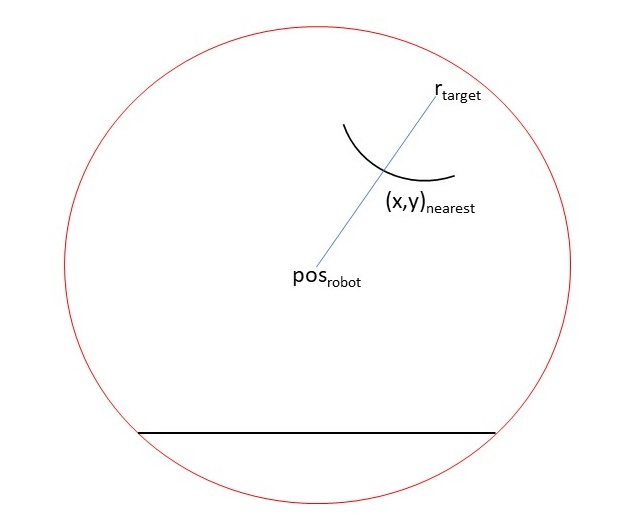

First, we find the nearest point of the segment to robot’s position, and then assume a straight line between this nearest point (x,y)nearest and robot’s potion posrobot . Obviously, the center of would-be circular target is on direction of this line with 0.5 meter distance from (x,y)nearst.

However, we would like to take errors into account while the geometry approach has nothing to do with errors. So, we have to turn our focus onto an statistical approach.

As I said, we have no idea about center of circular target and its radius which is 0.5 meters might have error. The only things that we have at out hand is points of segments or potions of arc(i.e. n(xi,yi)) which can describe a circle with radius of 0.5. Assume the center of this circular target is (x0,y0) and by following equation, we can define a circle.

$-r

0$

It looks like a regression formula but it is not a regression. Finding the best values of x0, y0 and r is our purpose with respect to we have actual observations!

∑ni=1((xi−x0)2+(yi−y0)2−−−−−−−−−−−−−−−−−−√−r)2

Then, out goal is minimization of the above formula through varying three values x0, y0 and r.

There are different way to do this minimization problem, namely, the grid approach, numerical optimization, using the first and second derivative to find the direction of descent and the size of movement, respectively, and stochastic search.

In the book, the approach of the first and second derivative was utilized via R function of nlm().

## Implementation
To use nlm() function, at first we must have a function to calculate the sum of squares which we saw in the above formula. This function would be somehow a cost function or evaluation function by which we can be aware of goodness of fitting values for x0, y0 and r.
furthermore, to use nlm() function, it needs an initial value to run. In this case, we should prepare three initial values for x0, y0 and r.

Think of initial value : it is possible to use geometry approach to get initial values for center of circle.

But in the book, the initial values for x0 and y0 are means of xi and yi , respectively.

Now, time to play!


In [ ]:
# now it's time to implement the main part of the case study. 
# the classifier

# this function will implement the error! goodness of fit!

def circleFitNLMfunc(self, x, y):
  # self is just for minimization function
  # p is a list of initial values 3 elements
  # x and y vectors which contain points of segments
  #print(self)

#  x0 = p[0]
#  y0 = p[1]
#  r = p[2]
  
  x0 = self[0]
  y0 = self[1]
  r = self[2]
  
  x = np.asarray(x)
  y = np.asarray(y)

  actual_r = np.sqrt((x-x0)**2 + (y - y0)**2)
  return sum((actual_r - r)**2)


In [ ]:
# a function to extract segments' ranges values.
# it gives segments indices as we implemented in getWrappedSegments() function and
# returns their values
def separateSegmentByDist(rangeLog, seg):
  # get list of segments
  # segs = getWrappedSegments(rangeLog, threshold = 2)
  
  # seg contains indices of a segment
  # try to extract range values of segments
  r = rangeLog.iloc[: , 3:-1].values.flatten()

  # postion of robot x0 , y0
  xdata = float(rangeLog.iloc[-1:]['x'])
  ydata = float(rangeLog.iloc[-1:]['y'])

  theta = np.linspace(-np.pi/2, (3*np.pi)/2, 360) # start from behind -90
  #r = logs[0][0].iloc[-1: , 3:-1].to_numpy()

  x1 = xdata + r*np.cos(theta)
  y1 = ydata + r*np.sin(theta)

  xi = []
  yi = []
  ri = []
  for s in seg:
    xi.append(x1[s])
    yi.append(y1[s])
    ri.append(r[s])
  
  return xi , yi, ri

6.029257210906598


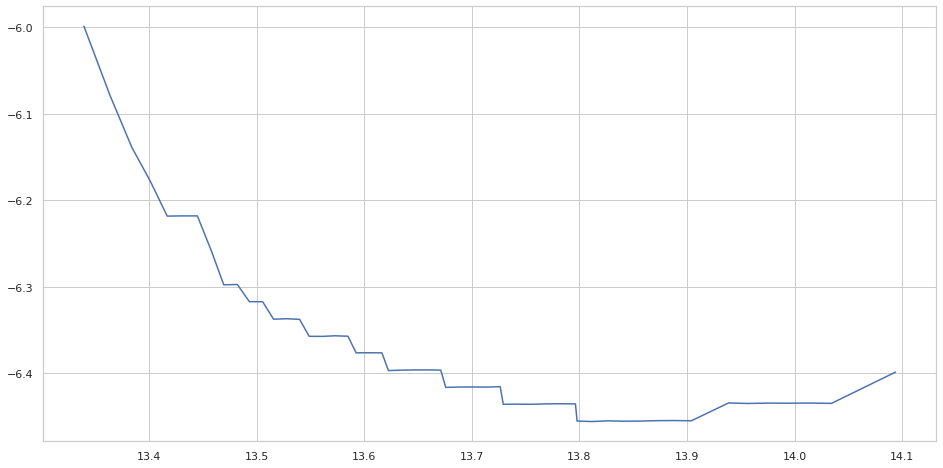

In [ ]:
# test of above function
#logs[0][0]
s = getWrappedSegments(logs[0][0].iloc[-1: ,])
x, y, rd = separateSegmentByDist(logs[0][0].iloc[-1: ,], s[1]) 
# the circular element which is on top of look of first log file
plt.plot(x,y)

p = [np.mean(x), np.mean(y), 0.5]
print(circleFitNLMfunc(p, x, y))
#np.mean(x)


As you can see, these values seemingly shows an arc!

In [ ]:
# non linear minimization
x, y, rd = separateSegmentByDist(logs[0][0].iloc[-1: ,], s[1]) 

minimize(circleFitNLMfunc, x0 = np.asarray([np.mean(x), np.mean(y), 0.5]), args=(x, y))
# the results exactly same as R

      fun: 0.0032531261084344596
 hess_inv: array([[0.20792442, 0.30483081, 0.3298228 ],
       [0.30483081, 0.69962477, 0.69607436],
       [0.3298228 , 0.69607436, 0.71169548]])
      jac: array([-1.66997779e-06, -7.11355824e-07,  2.80074892e-06])
  message: 'Optimization terminated successfully.'
     nfev: 95
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([13.86868307, -5.91098988,  0.53872023])

at above results:
*   fun : the minimum value of evaluation function which is **circleFitNLMfunc**
*   x: array => values for our 3 parameters which are x0, y0 and r of circular target
*   nit: number of iterations
*   hess_invobject: Inverse of the objective function’s Hessian; may be an approximation. Not available for all solvers.
*   nfev, njev, nhevint :Number of evaluations of the objective functions and of its Jacobian and Hessian.
*   fun, jac, hess: ndarray : Values of objective function, its Jacobian and its Hessian (if available). The Hessians may be approximations, see the documentation of the function in question.


In [ ]:
# testing other methods of minimization
x, y, rd = separateSegmentByDist(logs[0][0].iloc[-1: ,], s[1]) 
# the best methods : CG, BFGS, L-BFGS-B, trust-constr, 
minimize(circleFitNLMfunc, x0 = np.asarray([np.mean(x), np.mean(y), 0.5]), args=(x, y))

      fun: 0.0032531261084344596
 hess_inv: array([[0.20792442, 0.30483081, 0.3298228 ],
       [0.30483081, 0.69962477, 0.69607436],
       [0.3298228 , 0.69607436, 0.71169548]])
      jac: array([-1.66997779e-06, -7.11355824e-07,  2.80074892e-06])
  message: 'Optimization terminated successfully.'
     nfev: 95
      nit: 15
     njev: 19
   status: 0
  success: True
        x: array([13.86868307, -5.91098988,  0.53872023])

In [ ]:
# define a function for minimization 
# accepts a row of data frame as look! and a segment (index)
def circleFit(seg, rangeLog = logs[0][0].iloc[-1: ,]):

  x, y, rd = separateSegmentByDist(rangeLog, seg) 
  # the best methods : CG, BFGS, L-BFGS-B, trust-constr, 
  return minimize(circleFitNLMfunc, x0 = np.asarray([np.mean(x), np.mean(y), 0.5]), args=(x, y))

# test of this function
s = getWrappedSegments(logs[0][0].iloc[-1: ,])
z = circleFit(s[1], logs[0][0].iloc[-1: ,])


In [ ]:
z.status
z.x
rd

An other functions by which processing entire look of a robot is possible. It will extract segments with getWrappedSegments() and through a loop it will process all segments.

To use this function, three criteria should be taken into account.

1- having too few points in a segment like 3 points. With too few points, it is almost impossible to determine whether they belong to a circle or not. while the target is a circle, it will have 360 points. But, based on the seeing procedure of robots, they cannot collect all 360 points of the target, at the best case, 180 points of the target can be collected by the robot. Therefore, the number of points will be a tuning parameter. (min.length)

2- We should provide a threshold for the goodness of fit. As we have explained, out fitness function was formula 1. Although, we can use the direct result of nlm() function as a goodness of fit, different segments might have different lengths(varying number of points). So, we need a kind of independence from number of segments’ points . To do so, we can divide the result on nlm() function by number of points and set a threshold for decision.

(out$estimate / length(segment)) > max.ss.ratio

3- and the third constraint relates to radius. What happens if the estimated radius is far from 0.5 meter? in this case, it is most likely that the segment is not part of circular object.

In [ ]:

# this function is a kind of classifier and determine wether there is an arc in the look or not.
# look is a row of data frame == that is the final look or last row of the log file
# minLength: at least how many points should be in a segment to process
# for will end in case of finding the first segment which has a arc!

def robotEvaluation(look, minLength = 3, maxSSratio = 0.01, minRadius=0.5, maxRadius=2, rangeThreshold=2):
  # get segments
  segs = getWrappedSegments(look, rangeThreshold)
  # the separateSegments should be called here!

  # get robot position
  xdata = float(look.iloc[-1:]['x'])
  ydata = float(look.iloc[-1:]['y'])

  # loop over segments
  for s in segs:
    if len(s) < minLength:
      continue
    
    xi , yi, rd = separateSegmentByDist(look, s)
    # out is result of optimization function
    out = circleFit(s, look)

    if out.success == False:
      continue

    if(out.fun/len(s)) > maxSSratio:
      continue

    if(abs(out.x[2]) < minRadius) or (abs(out.x[2]) > maxRadius):
      continue


    return [xi, yi, rd, [xdata, ydata], out]

And apply this function of all 100 final looks:

In [ ]:
# doing classification over 100 final looks
circs = []
for log in logs:
  cir = robotEvaluation(log[0].iloc[-1: ,])
  #print(log[1])
  if cir is not None:
    circs.append([cir,log[1]])
# circs variable contains data about looks which have been detected there are acrs in them.

In [ ]:
#print(sum(c is not None for c in circs))
# which log files were detected as containing circular object
for c in circs:
  print(c[1])
print(len(circs))
#circs[0]

drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_31.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_50.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_13_09.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_39_46.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_40_42.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_40_04.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_45_20.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_51_58.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_52_37.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_03_46.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_04_25.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_22_17.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_23_33.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_42_01.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_41_42.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_42_40.log
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_13_50_46.log
drive/MyDrive/RobotLogs/JRSPdat

In [ ]:
# a function to plot the results of classification

# a function to plot all 100 final looks of log files
# n number of row in plot and m number of columns in plot
# pClass a set of log files' name in which we detect a circular target
def plotClassification(pClass, n = 10, m = 10):
  figure, axis = plt.subplots(n, m)

  for i in range(10):
    for j in range(10):
      #plotRobotLog(logs[0][0]['x'], logs[0][0]['y'])


      xdata = float(logs[i*10 + j][0].iloc[-1:]['x'])
      ydata = float(logs[i*10 + j][0].iloc[-1:]['y'])

      theta = np.linspace(-np.pi/2, (3*np.pi)/2, 360) # start from behind -90
      r = logs[i*10 + j][0].iloc[-1: , 3:-1].to_numpy()

      x1 = xdata + r*np.cos(theta)
      y1 = ydata + r*np.sin(theta)

      # a circle of radius 2 meters
      axis[i,j].plot(xdata + 2*np.cos(theta), ydata + 2*np.sin(theta), marker='.', color = 'red', markersize=0.5)

      # actual points
      # what the robot sees
      #axis[i,j].scatter(x=x1, y=y1, c = 'blue', s = 1)
      axis[i,j].plot(x1, y1, marker='.', color = 'blue', markersize=1)
      #axis[i,j].plot(x1, y1, marker='.', markersize=1.5, color = 'blue')
      
      axis[i,j].xaxis.set_visible(False)
      axis[i,j].yaxis.set_visible(False)

      #axis[i,j].set_axis_off()
      axis[i,j].set_aspect('equal')

      # change background based on postive or native class
      if (logs[i*10 + j][1] in pClass) == True:
        axis[i,j].set(facecolor = 'lime')
        #print(logs[i*10 + j][1])
      else: axis[i,j].set_facecolor('lavender')

      #plt.axis('off')
  plt.rcParams['figure.figsize'] = (24,16)
  plt.show()
  return

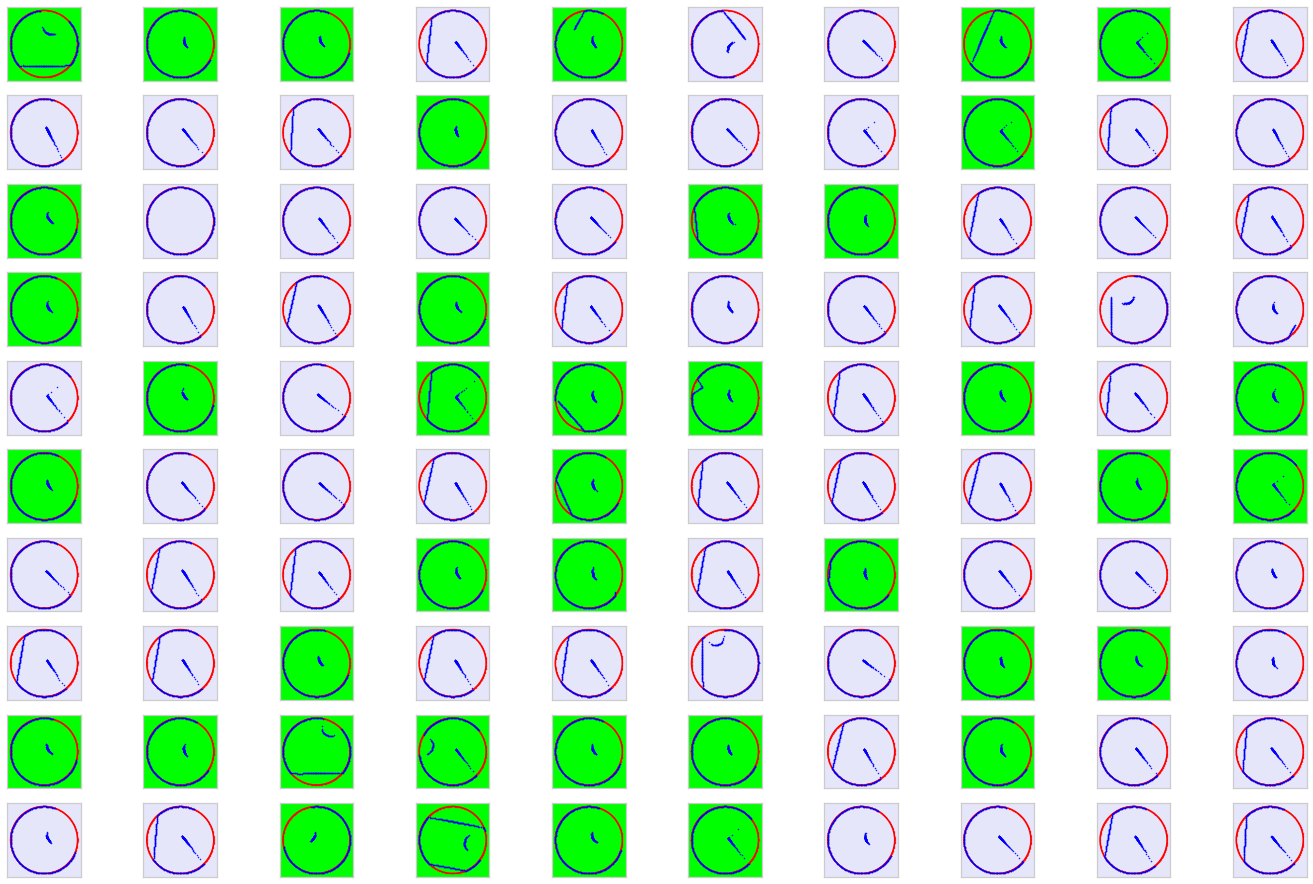

In [ ]:
pClass = set()
for c in circs:
  pClass.add(c[1])
  
pClass
plotClassification(pClass)

In [ ]:
# at some cases which were detected as containg circular target, we can see there are triangular like objetcs of edge of a rectangle instead of circular target. 
# For example last subplots of first and second lines
# cheking estimated radius of them.

for c in circs:
  print('{} and its x0,y0, and radius: {}'.format(c[1], c[0][4].x))
# they have high values of radius!

drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_31.log and its x0,y0, and radius: [13.86868307 -5.91098988  0.53872023]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_12_50.log and its x0,y0, and radius: [-10.31220347   4.98727432   0.57261019]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_13_09.log and its x0,y0, and radius: [ 5.19301006 -5.91368658  0.57206718]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_39_46.log and its x0,y0, and radius: [ 3.58830804 -2.76220695  0.58336541]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_40_42.log and its x0,y0, and radius: [ 5.40887685 -3.04138538  0.5555062 ]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_40_04.log and its x0,y0, and radius: [-10.63665141   3.25080437   0.99182954]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_45_20.log and its x0,y0, and radius: [-10.9308674   -4.08783159   0.72225534]
drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_12_51_58.log and its x0,y0, and radius: [-10.63665141   3.24980437   0.99182954]
drive/MyDriv

## Modification of the classifier
According to previous observations of misclassified cases, we have realized there were two problems.

The first problem happens when circular target is adjacent to an obstacle such that range values of them create a continuous segment and our segment detection function considers them as one single segment since all range values of these two different are less than 2 meters (the only criterion which is investigated to separate segments). Hence, if we have two distinct segments along each other, the robot will produce a sequence of range values less than 2 meters for them without any 2 meters values between the values of two segments which enable us to separate them.

How can we discover this problem and solve it? we should look at differences between consecutive range values. If there is a wide jump between them (relatively big difference , it is most likely that this point where two segments connect together and should be split into two segments.

In [ ]:
# a function to separate a segment based on consecutive range values differences
# parameters: segs, look, threshhold
def separateSegments(segs, look, threshold = 0.15):
  ret = []
  for seg in segs:
    dsplit = []
    xi, yi, ri =separateSegmentByDist(look,seg)
    #print(len(seg))
    #print(seg[0])
    #print(seg[len(seg)-1])
    xdiff = np.diff(xi)
    ydiff = np.diff(yi)
    d = np.sqrt(xdiff**2 + ydiff**2)
    dsplit = np.split(seg, np.where(np.diff(d) > threshold)[0] + 2)
    #print(len(dsplit))
    if len(dsplit) <= 1:
      ret.append(seg)
    else:
      for sp in dsplit:
        ret.append(list(sp))    
  return ret

inx = 75 # 5 and 38 and 75
sgs = getWrappedSegments(logs[inx][0].iloc[-1: ,])
print(len(sgs))
print(sgs)
x, y, r = separateSegmentByDist(logs[inx][0].iloc[-1: ,],sgs[0])
print(r)
print(x)
print(y)

sgs = separateSegments(sgs, logs[inx][0].iloc[-1: ,])
print(sgs)
x, y, r = separateSegmentByDist(logs[inx][0].iloc[-1: ,],sgs[0])
print('First segment')
print(r)
print(x)
print(y)
x, y, r = separateSegmentByDist(logs[inx][0].iloc[-1: ,],sgs[1])
print('second segment')
print(r)
print(x)
print(y)

2
[[182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217], [223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317]]
[1.605, 1.526, 1.447, 1.389, 1.331, 1.273, 1.276, 1.219, 1.222, 1.206, 1.21, 1.194, 1.179, 1.184, 1.19, 1.175, 1.182, 1.189, 1.175, 1.182, 1.19, 1.177, 1.186, 1.196, 1.184, 1.194, 1.205, 1.216, 1.228, 1.264, 1.278, 1.292, 1.331, 1.372, 1.433, 1.575]
[-6.066204003897164, -6.089419245927142, -6.109845898709972, -6.129499440704085, -6.1470

In [ ]:
inx = 5 # 5 and 38 and 75
sgs = getWrappedSegments(logs[inx][0].iloc[-1: ,])
print(len(sgs))
print(sgs)
sgs = separateSegments(sgs, logs[inx][0].iloc[-1: ,])
print(len(sgs))
print(sgs)

1
[[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]]
2
[[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,

In [ ]:
# ploting the last postion of robots in the course!
# it is in complete accordance wit the course!
fx = [] # x of all final looks
fy = [] # y of all final looks
for log in logs:
  #plotLook(log[0].iloc[-1:], log[1])
  fx.append(log[0].iloc[-1:]['x'])
  fy.append(log[0].iloc[-1:]['y'])

plt.plot(fx, fy, 'o')
plt.xlim([-16, +16])
plt.ylim([-8,+8])
plt.xticks(np.linspace(-16,+16,33))
plt.yticks(np.linspace(-8,+8,17))
plt.grid(True)
plotObstacles()
plt.rcParams['figure.figsize'] = (16,8)

drive/MyDrive/RobotLogs/JRSPdata_2010_03_10_14_48_08.log


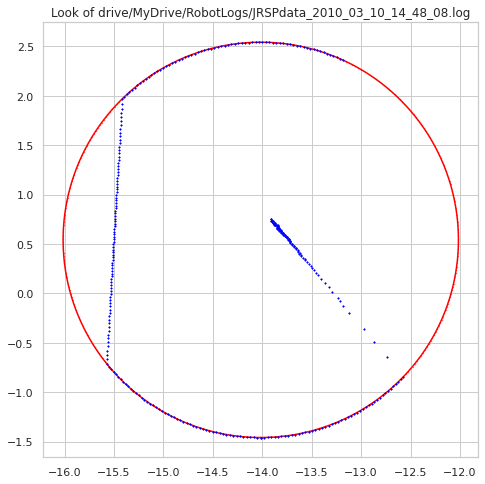

In [ ]:
'''
Since, we don't have specific target value with actual classification labels, I should build up a file in which there are at least two columns.
One column should illustrate name of each log file and the other one must indicate class label of that log file.
There isn't any resource to do that, so a simple and rather time consuming approach could be as following:
  1- draw the final look of each log file via plotLook(logs[0][0].iloc[-1:]) function.
  2- investigate the plotted look and decide whether it has circular target(as we have seen a part of circle of an arc) or not.
  3- if it has an arc its class label will be True otherwise the class label is set as False.
  4- repeat this procedure for all 100 final looks of log files!
Afterwards, we can utilize this file or table to obtain confusion matrix.
'''
# I have created a text file which its name is my_hasCircle
i = 99
plotLook(logs[i][0].iloc[-1:], logs[i][1])
print(logs[i][1])

In [ ]:
# load new file which I have created /text file
def readHasCircle(filename = "/content/drive/MyDrive/RobotLogs/my_hasCircle.txt"):
  hasCircle = pd.read_csv(filename, sep='\t')
  return hasCircle

hasCircle = readHasCircle()
print(hasCircle.info())
hasCircle[hasCircle['hasCircle']==True].count()
# 100 final looks which 44 of them contain circle and 56 have no circle!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      100 non-null    int64 
 1   logName    100 non-null    object
 2   hasCircle  100 non-null    bool  
 3   comment    52 non-null     object
dtypes: bool(1), int64(1), object(2)
memory usage: 2.6+ KB
None


index        44
logName      44
hasCircle    44
comment      28
dtype: int64

In [ ]:
# trueCases is a list of log names which detected as they have circular objects!

def createConfusionMatrix(hasCircle, trueCases = [], toplot = True, prefix = 'drive/MyDrive/RobotLogs/'):
  trueCases = set(trueCases)
  hasCircle['predicted'] = False
  for i in range(len(hasCircle)):
    if ((prefix + hasCircle.iloc[i]['logName']) in trueCases):
      hasCircle["predicted"][i] = True
  conMatrix = pd.crosstab(hasCircle['hasCircle'], hasCircle['predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)
  print(conMatrix)
  if toplot:
    conMatrix = pd.crosstab(hasCircle['hasCircle'], hasCircle['predicted'], rownames=['Actual'], colnames=['Predicted'], margins=False)
    sns.heatmap(conMatrix, annot=True)
  return hasCircle


In [ ]:
# test of confusion matrix print and plot
trueCases = []
for c in circs:
  trueCases.append(c[1])

createConfusionMatrix(hasCircle, trueCases, False)

Predicted  False  True  All
Actual                     
False         51     5   56
True           9    35   44
All           60    40  100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,logName,hasCircle,comment,predicted
0,0,JRSPdata_2010_03_10_12_12_31.log,True,NaN,True
1,1,JRSPdata_2010_03_10_12_12_50.log,True,very close to robot position,True
2,2,JRSPdata_2010_03_10_12_13_09.log,True,close to robot position,True
3,3,JRSPdata_2010_03_10_12_13_29.log,False,NaN,False
4,4,JRSPdata_2010_03_10_12_39_46.log,True,unconfident,True
...,...,...,...,...,...
95,95,JRSPdata_2010_03_10_14_41_31.log,False,NaN,True
96,96,JRSPdata_2010_03_10_14_48_27.log,True,NaN,False
97,97,JRSPdata_2010_03_10_14_47_30.log,False,just one line on the right,False
98,98,JRSPdata_2010_03_10_14_47_49.log,False,NaN,False


In [ ]:
# doing classification over 100 final looks with modified inputs!
circs = []
for log in logs:
  cir = robotEvaluation(log[0].iloc[-1: ,],  maxRadius = 0.9, minRadius = 0.475)
  #print(log[1])
  if cir is not None:
    circs.append([cir,log[1]])
# circs variable contains data about looks which have been detected there are acrs in them.

In [ ]:
# confusion matrix after modification
trueCases = []
for c in circs:
  trueCases.append(c[1])

createConfusionMatrix(hasCircle, trueCases, False)

Predicted  False  True  All
Actual                     
False         56     0   56
True           9    35   44
All           65    35  100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,logName,hasCircle,comment,predicted
0,0,JRSPdata_2010_03_10_12_12_31.log,True,NaN,True
1,1,JRSPdata_2010_03_10_12_12_50.log,True,very close to robot position,True
2,2,JRSPdata_2010_03_10_12_13_09.log,True,close to robot position,True
3,3,JRSPdata_2010_03_10_12_13_29.log,False,NaN,False
4,4,JRSPdata_2010_03_10_12_39_46.log,True,unconfident,True
...,...,...,...,...,...
95,95,JRSPdata_2010_03_10_14_41_31.log,False,NaN,False
96,96,JRSPdata_2010_03_10_14_48_27.log,True,NaN,False
97,97,JRSPdata_2010_03_10_14_47_30.log,False,just one line on the right,False
98,98,JRSPdata_2010_03_10_14_47_49.log,False,NaN,False


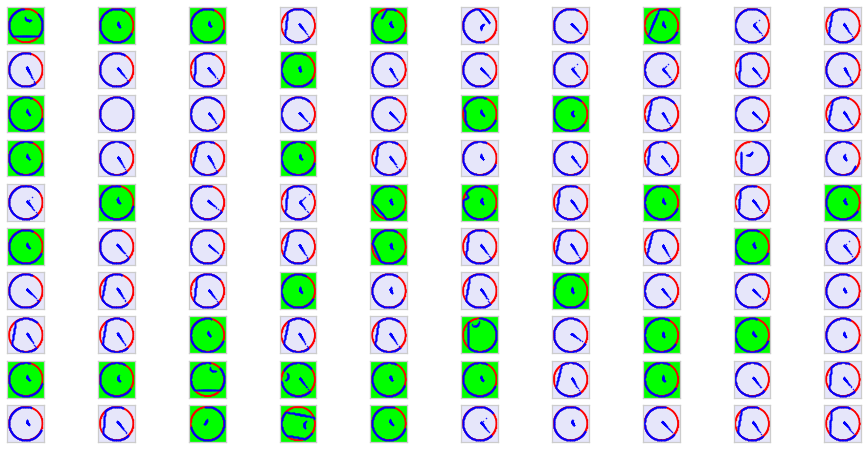

In [ ]:
# plot looks after modification
pClass = set()
for c in circs:
  pClass.add(c[1])
  
pClass
plotClassification(pClass)